In [1]:
#Control time packages
import time
import os


#General packages
import numpy as np
from My_Jampy import JAM
import emcee
import matplotlib.pyplot as plt


#Constants and usefull packages
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s


#Dataset path
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/Emcee/Data/"

In [2]:
#Reading MGE inputs
    #attention to units
surf_lum, sigma_lum, qobs_lum = np.loadtxt(data_folder+"JAM_Input.txt", unpack=True)          #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt(data_folder+"SDP81_pseudo-DM_halo.txt", unpack=True)    #DM component
norm_psf, sigma_psf           = np.loadtxt(data_folder+"MUSE_Psf_model.txt", unpack=True)     #PSF
ybin, xbin, vrms, erms        = np.loadtxt(data_folder+"pPXF_rot_data.txt", unpack=True)          #Vrms data

muse_pixsize = 0.2                            #Muse pixel size [arcsec/px]

z_lens   = 0.299                                    #Lens redshifth
z_source = 3.100                                    #Source redshift

#Angular diameter distances
D_l = cosmo.angular_diameter_distance(z_lens)                   #Lens              
D_s = cosmo.angular_diameter_distance(z_source)                 #Source
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)   #Lens to source


#This quantities are our unknown parameters
inc       = 75                              #Inclination [deg]
mbh       = 1e10                            #Mass of black hole [M_sun]
beta      = np.full_like(surf_lum, 0.3)     #Anisotropy
ml        = 10                              #Mass to light ratio [M_sun/L_sun]
rho_s     = 1e10                            #dark matter intensity
qdm       = np.full_like(qobs_dm, 0.5)      #dark matter axial ratio
    

#--------------------------------------------------------------------------------------------------#
# JAMPY MODEL

Jam_model = JAM(ybin=ybin, xbin=xbin, inc=inc, distance=D_l.value, mbh=mbh, beta=beta, rms=vrms,
                erms=erms,normpsf=norm_psf, sigmapsf=sigma_psf*muse_pixsize, pixsize=muse_pixsize)

    #Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                qobs_lum=qobs_lum, ml=ml)
    #Add DM component
Jam_model.DM_component(surf_dm=rho_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qdm)

In [8]:
#--------------------------------------- EMCEE ------------------------------------------------------#

### Priors

###boundaries. [lower, upper]
boundary = {'qinc': [0.0501, np.min(qobs_lum)], 'beta': [-5, 5], 'ml': [0.5, 15], 'log_mbh':[5, 11],
                'log_rho': [3, 11], 'qDM': [0.4, 1]}





def check_boundary(parsDic):
    """
        Check whether parameters are within the boundary limits
        input
            parsDic: parameter dictionary {'paraName', value}
        output
            -np.inf or 0.0
    """   

    #Check if beta is ok

    #Avoid beta[i] == 1, because this could cause problems
    for i in range(len(parsDic['beta'])):
        if parsDic['beta'][i] != 1:
            pass
        else:
            return -np.inf

    #Check beta boundary
    for i in range(len(parsDic['beta'])):
        if boundary['beta'][0] < parsDic['beta'][i] < boundary['beta'][1] :
            pass
        else:
            return -np.inf




    #Check if the others parameters are within the boundary limits
    keys = set(parsDic.keys())
    excludes = set(['beta'])  #Exclude beta and ml, because we already verify above

    
    for keys in keys.difference(excludes):
        if boundary[keys][0] <= parsDic[keys] <= boundary[keys][1]:
            pass
        else:
            return -np.inf
    return 0.0

def log_prior(parsDic):
    '''
    Calculate the prior lnprob
    input
      parsDic: parameter dictionary {'paraName', value}
    output
      lnprob
    '''
    
    rst = 0
    """
    The lines above is only for doble check, because we are assuming flat prior for all parameters, Once we got here, all values ​​have already been accepted, so just return 0.0 for one of them
    """

    rst += 0.0     #mass-to-light
    rst += 0.0     #beta
    rst += 0.0     #qinc
    rst += 0.0     #log_mbh
    rst += 0.0     #log_rho
    rst += 0.0     #qDM

    
    return rst


def Updt_JAM(parsDic):
    '''
       Update the dynamical mass model
    input
      parsDic: parameter dictionary {'paraName', value}
    '''

        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 - parsDic['qinc']**2))))
   

    ml_model  = parsDic['ml']                        #mass-to-light update 
    mbh_model = 10**parsDic['log_mbh']               #BH mass
    rho_model = 10**parsDic['log_rho']               #rho DM
    qdm_proj  = np.sqrt( (np.sin(np.radians(inc_model)) * parsDic['qDM'] )**2  + np.cos( np.radians(inc_model))**2     )                            #Projected DM axial ratio
    qdm_model = np.full_like(surf_dm, qdm_proj)      #qDM

    #We project the DM axial ratio because during the JAM fit it will be deprojected.

    #Model Updt
    Jam_model.upt(inc=inc_model, ml=ml_model, beta=parsDic['beta'], mbh=mbh_model,
                        surf_dm= rho_model * surf_dm, qobs_dm=qdm_model)


def JAM_log_likelihood(parsDic):
    """
        Perform JAM modeling and return the chi2
    """
    Updt_JAM(parsDic)               #Updt values for each iteration
    
    rmsModel, ml, chi2, chi2T = Jam_model.run(plot=True, quiet=False)
    plt.tight_layout()
    plt.show()
    return -0.5 * chi2T


def log_probability(pars):
    """
        Log-probability function for whole model.
        input:
            pars: current values in the Emcee sample.
        output:
            log probability for the combined model.
    """

    (ml, b1, b2, b3, b4, b5, b6, b7, b8, qinc, log_mbh, log_rho, qdm) = pars
    
    beta =  np.array([b1, b2, b3, b4, b5, b6, b7, b8])


    parsDic = {'ml': ml, 'beta': beta, 'qinc': qinc, 'log_mbh': log_mbh,
                        'log_rho': log_rho, 'qDM': qdm}

    
    #Checking boundaries
    if not np.isfinite(check_boundary(parsDic)):
        return -np.inf
    #calculating the log_priors
    lp = log_prior(parsDic)

    return lp + JAM_log_likelihood(parsDic)

In [4]:
def call_model(x0):
    #print(x0)
    value =  log_probability(x0)
    #print(value)
    if np.isfinite(value):
        return -value
    else:
        return 1e200

In [19]:
from scipy.optimize import differential_evolution
#In order: ML, b1, b2, b3, b4, b5, b6, b7, qinc, log_mbh, log_rho_s, qDM
bounds = [(0.5, 15), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), 
              (0.05, np.min(qobs_lum)), (6, 12), (6, 12), (0.4, 1)]

In [23]:
result = differential_evolution(call_model,maxiter=1, bounds=bounds, updating='deferred', disp=True)

differential_evolution step 1: f(x)= 3534.66


/home/carlos/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [25]:
print(result)

     fun: 3534.6577637625205
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 432
     nit: 1
 success: False
       x: array([11.24112671,  2.59282532, -3.5932524 ,  1.42724987, -1.8786763 ,
       -0.10057962,  0.60848452,  4.97162652, -0.15600166,  0.22566414,
        6.81187141, 10.3233692 ,  0.74992628])


In [ ]:
ML  12.11
b1  0.99
b2  1.02
b3  0.68
b4  0.47
b5  0.88
b6  -1.59
b7  0.62
b8  -0.14
inclination  0.54
log_mbh  7.21
log_rho_s  9.02
qDM  0.78


In [5]:
x0 = np.array([12.11, 0.99, 1.02, 0.68, 0.47, 0.88, -1.59, 0.62, -0.14, 0.54, 7.21, 9.02, 0.78])

jam_axi_rms elapsed time sec: 0.45
inc=82.9 beta_z=0.99 M/L=1 BH=1.62e+07 chi2/DOF=24.7
Total mass MGE: 1.073e+12


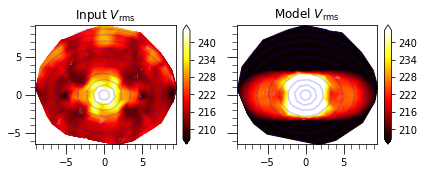

2876.739518339607

In [9]:
call_model(x0)

In [12]:
x0 = np.array([14.92821134,  0.99974916,  1.41316151,  1.01243791,  0.8524248,
        1.1314737 , -1.08874912,  0.67610216,  0.07880484,  0.55      ,
        8.76948922, 11.        ,  0.99930751])

/home/carlos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in double_scalars


jam_axi_rms elapsed time sec: 0.47
inc=90.0 beta_z=1.00 M/L=1 BH=5.88e+08 chi2/DOF=10.2
Total mass MGE: 3.453e+12


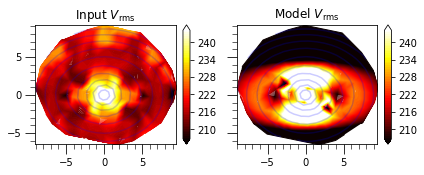

1187.933740923514

In [13]:
call_model(x0)

jam_axi_rms elapsed time sec: 0.45
inc=87.5 beta_z=0.31 M/L=1 BH=6.68e+07 chi2/DOF=19.9
Total mass MGE: 3.052e+12


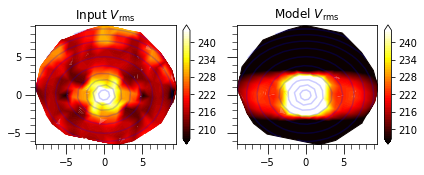

2318.6988426556745

In [15]:
call_model(np.array([10.52324904,  0.31005887,  1.03186412,  4.87942555,  0.4796032,
        0.87033877, -2.79672689,  0.59840256, -0.05791264,  0.54880527,
        7.82447736, 10.99926601,  0.99299304]))

jam_axi_rms elapsed time sec: 0.46
inc=85.8 beta_z=1.82 M/L=1 BH=2.04e+07 chi2/DOF=24.6
Total mass MGE: 1.221e+12


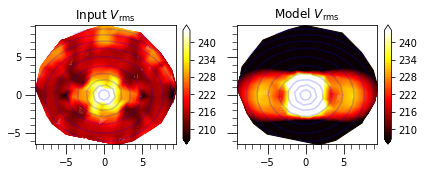

2861.256156185463

In [16]:
call_model(np.array([12.05699358,  1.82132819,  1.03399201, -1.63792948,  0.61878234,
        0.81717043, -0.94809611,  0.61307441, -0.1861905 ,  0.54665144,
        7.31047231,  9.91424813,  0.96223458])
)

jam_axi_rms elapsed time sec: 0.47
inc=90.0 beta_z=1.00 M/L=1 BH=6.52e+08 chi2/DOF=12.5
Total mass MGE: 1.523e+12


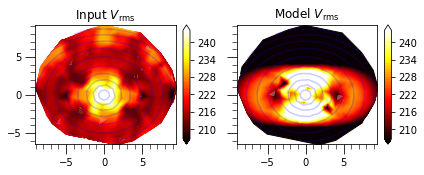

1453.037922111687

In [17]:
call_model(np.array([ 1.49999987e+01,  9.99712941e-01, -1.19778855e+00,  1.01447012e+00,
        8.17540940e-01,  1.21431331e+00, -1.27924297e+00,  6.77919919e-01,
       -5.70505967e-03,  5.49999953e-01,  8.81416700e+00,  9.99999992e+00,
        9.99079100e-01]))